# A Tutorial of Implementation of Finite Element Methods  
<div style="text-align: right"> *--- Based on Xiaoming He's lecture at UESTC, and re-demonstrated with Jupyter notebook* </div> 
<div style="text-align: center"> __Xiaozhou Li (University of Electronic Science and Technology of China)__ </div>
## 1D Poisson Equation
## Basic Framework
- Generate the information matrices: P, T, E;
- Assembel the matrices and vectors: local assembly based on P, T, E only;
- Deal with the boundary conditions: boundary information matrix and local assembly;
- Solve linear systems: numerical linear algebra.

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import GaussQuad as GQ

In [92]:
def local_basis_1D(x, vertices, basis_type, basis_index,der_order):
    #basis_type==101: 1D linear basis functions
    #basis_type==102: 1D quadratic basis functions
    
    left = vertices[0]
    right = vertices[1]
    h = right - left
    if (basis_type==101):
        if (basis_index==0):
            if (der_order==0):
                r = (right - x)/h
            elif (der_order==1):
                r = -1/h
            elif (der_order>1):
                r = 0.
            else:
                print ("wrong der order")
        elif (basis_index==1):
            if (der_order==0):
                r = (x - left)/h
            elif (der_order==1):
                r = 1/h
            elif (der_order>1):
                r = 0
            else:
                print ("wrong der order")
    elif (basis_type==102):
        if (basis_index==0):
            if (der_order==0):
                r = 2*((x-left)/h)**2 - 3*(x-left)/h + 1
            elif (der_order==1):
                r = 4*(x-left)/h**2 - 3/h
            elif (der_order==2):
                r = 4/h**2 
            elif (der_order>2):
                r = 0
            else:
                print ("wrong der order")
        elif (basis_index==1):
            if (der_order==0):
                r = 2*((x-left)/h)**2 - (x-left)/h
            elif (der_order==1):
                r = 4*(x-left)/h**2 - 1/h
            elif (der_order==2):
                r = 4/h**2 
            elif (der_order>2):
                r = 0
            else:
                print ("wrong der order")
        elif (basis_index==2):
            if (der_order==0):
                r = -4*((x-left)/h)**2 + 4*(x-left)/h
            elif (der_order==1):
                r = -8*(x-left)/h**2 + 4/h
            elif (der_order==2):
                r = -8/h**2 
            elif (der_order>2):
                r = 0
            else:
                print ("wrong der order")
    return r

def generate_Gauss1D(vertices, Gauss_points_ref, Gauss_weights_ref):
    mid  = 0.5*(vertices[0] + vertices[1])
    scale = 0.5*(vertices[1] - vertices[0])
    return mid + scale*Gauss_points_ref, scale*Gauss_weights_ref

def generate_Nlb(basis_type):
    if (basis_type==101):
        Nlb = 2
    elif (basis_type==102):
        Nlb = 3
    return Nlb

- Define your global indices for all the mesh elements and mesh nodes. Let $N$ denote the number of mesh elements and $N_m$ denote the number of mesh nodes. Here $N_m = N + 1$.
- Define matrix $P$ to be an information matrix consisting of the coordinates of all mesh nodes.
- Define matrix $T$ to be an information matrix consisting of the global node indices of the mesh nodes of all the mesh elements.

In [93]:
def generate_PT_1D(left_boundary, right_boundary, number_of_elements):
    P = np.linspace(left_boundary, right_boundary, number_of_elements+1)
    T = np.zeros([2, number_of_elements], dtype=int)
    for j in range (number_of_elements):
        T[0,j] = j
        T[1,j] = j+1
    return P, T

left_boundary = 0
right_boundary = 1
number_of_elements = 10
P, T = generate_PT_1D(left_boundary, right_boundary, number_of_elements)

- Let $N_b$ denote the total number of the finite element basis functions (= the number of unknowns = the total number of the finite element nodes). Here $N_b = N + 1$.
- Define matrix $P_b$ to be an information matrix consisting of the coordinates of all finite element nodes.
- Define matrix $T_b$ to be an information matrix consisting of the global node indices of the finite element nodes of all the mesh elements.

In [94]:
def generate_NbPbTb_1D(P, T, basis_type):
    if (basis_type==101):
        Nb = np.size(P)
        Pb = np.copy(P)
        Tb = np.copy(T)
    elif (basis_type==102):
        Nb = 2*np.size(P)-1
        Pb = np.zeros(Nb)
        Pb[0::2] = P
        for i in range (np.size(P)-1):
            Pb[2*i+1] = 0.5*(Pb[2*i] + Pb[2*i+2])
        Tb = np.zeros([3,np.size(P)-1],dtype=int)
        Tb[0:2,:] = T*2
        Tb[2,:] = Tb[1,:]-1
    return Nb, Pb, Tb

# local debugging codes
basis_type = 102
Nb, Pb, Tb = generate_NbPbTb_1D(P, T, basis_type)
print (Nb)
print (Pb)
print (Tb)

21
[ 0.    0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55
  0.6   0.65  0.7   0.75  0.8   0.85  0.9   0.95  1.  ]
[[ 0  2  4  6  8 10 12 14 16 18]
 [ 2  4  6  8 10 12 14 16 18 20]
 [ 1  3  5  7  9 11 13 15 17 19]]


In [112]:
# left, right boundary
left_boundary = 0
right_boundary = 1

# number of elements, also size(T[0])
number_of_elements = 4

# P, T matrice
P, T = generate_PT_1D(left_boundary, right_boundary, number_of_elements)

basis_type_trial = 102
basis_type_test = 102

# Nlb, number of local basis
Nlb_trial = generate_Nlb(basis_type_trial)
Nlb_test  = generate_Nlb(basis_type_test)
Nb_trial, Pb_trial, Tb_trial = generate_NbPbTb_1D(P, T, basis_type_trial)
Nb_test,  Pb_test,  Tb_test  = generate_NbPbTb_1D(P, T, basis_type_test)

print (Tb_trial)
# Gauss point number
Gpn = 6
Gauss_points_ref, Gauss_weights_ref = GQ.LegendreQuad(Gpn)
# Gauss_points, Gauss_weights = generate_Gauss1D([0,1], Gauss_points_ref, Gauss_weights_ref)

def coeff_fun(x):
    #return 1
    return np.exp(x) 

[[0 2 4 6]
 [2 4 6 8]
 [1 3 5 7]]


In [113]:
def Gauss_int_1D_trial_test(Gpn, Gauss_points, Gauss_weights, coeff_fun, vertices, \
                            der_order_trial, basis_type_trial, basis_index_trial, \
                            der_order_test,  basis_type_test,  basis_index_test):
    int_value = 0.
    for k in range (Gpn):
        int_value += Gauss_weights[k]*coeff_fun(Gauss_points[k])*\
                        local_basis_1D(Gauss_points[k],vertices, basis_type_trial, basis_index_trial, der_order_trial)*\
                        local_basis_1D(Gauss_points[k],vertices, basis_type_test, basis_index_test, der_order_test)
    return int_value

In [114]:
def assemble_matrix_1D(coeff_fun, Gauss_points_ref, Gauss_weights_ref, 
                       P, T, Tb_trial, Tb_test, Nlb_trial, Nlb_test, Nb_trial, Nb_test,\
                       basis_type_trial, der_order_trial, basis_type_test, der_order_test):
    A = np.zeros([Nb_test, Nb_trial])
    for n in range(number_of_elements):
        vertices = P[T[0,n]:T[1,n]+1]
        Gauss_points, Gauss_weights=generate_Gauss1D(vertices, Gauss_points_ref, Gauss_weights_ref)
        for alpha in range(Nlb_trial):
            for beta in range(Nlb_test):
                int_value=Gauss_int_1D_trial_test(Gpn, Gauss_points, Gauss_weights, coeff_fun, vertices, \
                                                    der_order_trial, basis_type_trial, alpha, \
                                                    der_order_test,  basis_type_test,  beta)
                A[Tb_trial[beta,n],Tb_test[alpha,n]] += int_value
    return A          

#print (Nb_trial, Nb_test, np.shape(Tb_trial), np.shape(Tb_test))
A = assemble_matrix_1D(coeff_fun, Gauss_points_ref, Gauss_weights_ref, 
                       P, T, Tb_trial, Tb_test, Nlb_trial, Nlb_test, Nb_trial, Nb_test,\
                       basis_type_trial, 1, basis_type_test, 1)
print (A)



[[  9.85960683 -11.38701365   1.52740682   0.           0.           0.
    0.           0.           0.        ]
 [-11.38701365  24.28725394 -12.9002403    0.           0.           0.
    0.           0.           0.        ]
 [  1.52740682 -12.9002403   24.03281924 -14.62121494   1.96122918   0.
    0.           0.           0.        ]
 [  0.           0.         -14.62121494  31.18545136 -16.56423642   0.
    0.           0.           0.        ]
 [  0.           0.           1.96122918 -16.56423642  30.85875074
  -18.77401161   2.51826811   0.           0.        ]
 [  0.           0.           0.           0.         -18.77401161
   40.04291218 -21.26890057   0.           0.        ]
 [  0.           0.           0.           0.           2.51826811
  -21.26890057  39.62342028 -24.10630808   3.23352026]
 [  0.           0.           0.           0.           0.           0.
  -24.10630808  51.416117   -27.30980892]
 [  0.           0.           0.           0.           0.      

In [115]:
def source_fun(x):
    #return 0.
    return -np.exp(x)*(np.cos(x)-2*np.sin(x)-x*np.cos(x)-x*np.sin(x))

def Gauss_int_1D_source_test(Gpn, Gauss_points, Gauss_weights, source_fun, vertices, \
                            der_order_test,  basis_type_test,  basis_index_test):
    int_value = 0.
    for k in range (Gpn):
        int_value += Gauss_weights[k]*source_fun(Gauss_points[k])*\
                        local_basis_1D(Gauss_points[k], vertices, basis_type_test, basis_index_test, der_order_test)
    return int_value

def assemble_vector_1D(source_fun, Gauss_points_ref, Gauss_weights_ref, \
                       P, T, Tb_test, Nlb_test, Nb_test, basis_type_test, der_order_test):
    b = np.zeros(Nb_test)
    for n in range(number_of_elements):
        vertices = P[T[0,n]:T[1,n]+1]
        Gauss_points, Gauss_weights=generate_Gauss1D(vertices, Gauss_points_ref, Gauss_weights_ref)
        for beta in range(Nlb_test):
            int_value=Gauss_int_1D_source_test(Gpn, Gauss_points, Gauss_weights, source_fun, vertices, \
                                                der_order_test,  basis_type_test,  beta)
            b[Tb_test[beta,n]] += int_value
    return b

b = assemble_vector_1D(source_fun, Gauss_points_ref, Gauss_weights_ref, \
                       P, T, Tb_test, Nlb_test, Nb_test, basis_type_test, 0)
print (b)
#print (np.size(b))

[-0.04284023 -0.11144663 -0.02106602  0.07317662  0.10081148  0.38740051
  0.29444734  0.85424342  0.28393486]


### Treat boundary conditions
In general: 
- Boundary information matrix boundarynodes: 
- boundarynodes[0,k] is the type of the kth boundary finite element node: Dirichlet, Neumann, Robin......
- boundarynodes[1,k] is the global node index of the kth boundary finite element node.
- Set nbn to be the number of boundary finite element nodes;
- Algorithm III can be reorganized into a more general framework by using the boundary information matrix boundarynodes.

#### Dirichlet boundary conditions
- Define $g(x)$ to be the boundary function which satisfies $g(a)=g_a$ and $g(b)=g_b$;

4.65966895148e-05


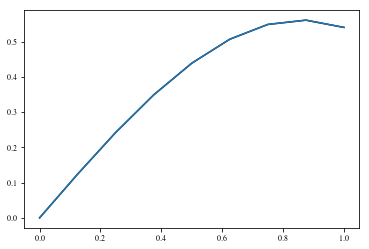

In [118]:
def generate_boundarynodes_1D(Pb):
    nbn = 2
    boundarynodes = np.zeros([2,nbn],dtype=int)
    # boundarynodes[0,i] = 0, Dirichlet
    boundarynodes[1,0] = 0
    boundarynodes[1,1] = np.size(Pb)-1
    return nbn, boundarynodes

nbn, boundarynodes = generate_boundarynodes_1D(Pb_trial)
#print (nbn)
#print (boundarynodes)

def Dirichlet_fun(x):
    if (x <= left_boundary+1.e-10):
        return 0.
    elif (x >= right_boundary - 1.e-10):
        return np.cos(1)

def treat_Dirichlet_boundary(A, b, Pb, nbn, boundarynodes, Dirichlet_fun):
    for k in range(nbn):
        if (boundarynodes[0,k] == 0):
            i = boundarynodes[1,k]
            A[i,:] = 0
            A[i,i] = 1
            b[i] = Dirichlet_fun(Pb[i])
    return A, b

def exact_fun(x):
    return x*np.cos(x)

A, b = treat_Dirichlet_boundary(A, b, Pb_trial, nbn, boundarynodes, Dirichlet_fun)
#print (A, b)

u = np.linalg.solve(A,b)
#print (u)
err = np.zeros(np.size(Pb_trial))
for i in range (np.size(Pb_trial)):
    err[i] = np.abs(u[i] - exact_fun(Pb_trial[i]))
print (np.max(err))

plt.plot(Pb_trial, u, 'k')
plt.plot(Pb_trial, Pb_trial*np.cos(Pb_trial))
plt.show()

In [122]:
def Poisson1D_solver(left_boundary, right_boundary, number_of_elements, basis_type,\
                     Gpn, coeff_fun, source_fun, Dirichlet_fun, exact_fun):
    # P, T matrice
    P, T = generate_PT_1D(left_boundary, right_boundary, number_of_elements)

    basis_type_trial = basis_type
    basis_type_test  = basis_type

    # Nlb, number of local basis
    Nlb_trial = generate_Nlb(basis_type_trial)
    Nlb_test  = generate_Nlb(basis_type_test)
    Nb_trial, Pb_trial, Tb_trial = generate_NbPbTb_1D(P, T, basis_type_trial)
    Nb_test,  Pb_test,  Tb_test  = generate_NbPbTb_1D(P, T, basis_type_test)

    # Gauss point number
    Gauss_points_ref, Gauss_weights_ref = GQ.LegendreQuad(Gpn)
    
    # Assemble local to global
    A = assemble_matrix_1D(coeff_fun, Gauss_points_ref, Gauss_weights_ref, 
                       P, T, Tb_trial, Tb_test, Nlb_trial, Nlb_test, Nb_trial, Nb_test,\
                       basis_type_trial, 1, basis_type_test, 1)
    b = assemble_vector_1D(source_fun, Gauss_points_ref, Gauss_weights_ref, \
                       P, T, Tb_test, Nlb_test, Nb_test, basis_type_test, 0)
    
    # deal with boundary
    nbn, boundarynodes = generate_boundarynodes_1D(Pb_trial)
    # Dirichlet boundary
    A, b = treat_Dirichlet_boundary(A, b, Pb_trial, nbn, boundarynodes, Dirichlet_fun)
    
    # solve the solution
    u = np.linalg.solve(A,b)
    #print (u)
    
    # maximum error at nodes 
    err = np.zeros(np.size(Pb_trial))
    for i in range (np.size(Pb_trial)):
        err[i] = np.abs(u[i] - exact_fun(Pb_trial[i]))
    
    return np.max(err), Pb_trial, u
#
err, Pb, u = Poisson1D_solver(left_boundary, right_boundary, number_of_elements, 102,\
                     Gpn, coeff_fun, source_fun, Dirichlet_fun, exact_fun)
print ("%7.2e" % err)

def FE_solution(x, uh_local, vertices, basis_type, Nlb, der_order):
    result = 0.
    for i in range(Nlb):
        result += uh_local[i]*local_basis_1D(x, vertices, basis_type, i, der_order)
    return result

4.61e-11


\begin{example}\label{example:1}
    Use the 1D linear finite element method to solve the following equation:
    \begin{align*}
         -\frac{d}{dx}\left(e^x\frac{d u(x)}{dx}\right) &= -e^x[\cos(x)-2\sin(x)-x\cos(x) - x\sin(x)],\,\, (0 \leq x \leq 1), \\
         u(0) &= 0,\,\,u(1) = \cos(1).
    \end{align*}
    \begin{itemize}
        \item The analytic solution of this problem is $u = x\cos(x)$, which can be used to compute the error of the numerical solution.
        \item Second order convergence $\mathcal{O}(h^2)$ since the error is reduced by $1$ when $h$ is reduced by half.
        \item This matches the optimal approximation capability expected from piecewise linear functions.
    \end{itemize}
\end{example}

h      maximum absolute error    order
1/4           2.33e-03            --
1/8           5.83e-04           2.00
1/16          1.46e-04           1.99
1/32          3.67e-05           2.00
1/64          9.17e-06           2.00
1/128         2.29e-06           2.00


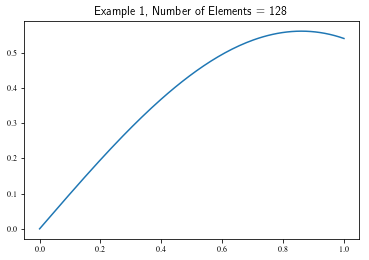

In [124]:
left_boundary_ex1 = 0
right_boundary_ex1 = 1

Gpn = 6 

def coeff_fun_ex1(x):
    return np.exp(x) 

def source_fun_ex1(x):
    return -np.exp(x)*(np.cos(x)-2*np.sin(x)-x*np.cos(x)-x*np.sin(x))

def Dirichlet_fun_ex1(x):
    tiny = 1.e-12
    if (x <= left_boundary_ex1 + tiny):
        return 0.
    elif (x >= right_boundary_ex1 - tiny):
        return np.cos(1)

def exact_fun_ex1(x):
    return x*np.cos(x)

number_coarse = 4
basis_type = 101
print ("h      maximum absolute error    order")
err = np.zeros(6)
for i in range (6):
    number_of_elements = number_coarse*2**i
    if (i < 5):
        err[i], _, _ = Poisson1D_solver(left_boundary_ex1, right_boundary_ex1, number_of_elements, basis_type,\
                             Gpn, coeff_fun_ex1, source_fun_ex1, Dirichlet_fun_ex1, exact_fun_ex1)
    elif (i == 5):
        err[i], Pb, u = Poisson1D_solver(left_boundary_ex1, right_boundary_ex1, number_of_elements, basis_type,\
                             Gpn, coeff_fun_ex1, source_fun_ex1, Dirichlet_fun_ex1, exact_fun_ex1)
    if (i == 0):
        print ("1/%-3d         %7.2e            --" % (number_of_elements, err[i]))
    else:
        print ("1/%-3d         %7.2e           %4.2f" % (number_of_elements, err[i], np.log(err[i-1]/err[i])/np.log(2)))

plt.plot(Pb, u)
plt.title("Example 1, Number of Elements = %3d" % number_of_elements)
plt.show()

\begin{example}\label{example:2}
    Use the 1D quadratric finite element method to solve the following equation:
    \begin{align*}
         -\frac{d}{dx}\left(e^x\frac{d u(x)}{dx}\right) &= -e^x[\cos(x)-2\sin(x)-x\cos(x) - x\sin(x)],\,\, (0 \leq x \leq 1), \\
         u(0) &= 0,\,\,u(1) = \cos(1).
    \end{align*}
    \begin{itemize}
        \item The analytic solution of this problem is $u = x\cos(x)$, which can be used to compute the error of the numerical solution.
        \item Second order convergence $\mathcal{O}(h^3)$ since the error is reduced by $1$ when $h$ is reduced by half.
        \item This matches the optimal approximation capability expected from piecewise quadratric functions.
    \end{itemize}
\end{example}

h      maximum absolute error    order
1/4           4.66e-05            --
1/8           2.99e-06           3.96
1/16          1.89e-07           3.98
1/32          1.19e-08           3.99
1/64          7.44e-10           4.00
1/128         4.61e-11           4.01


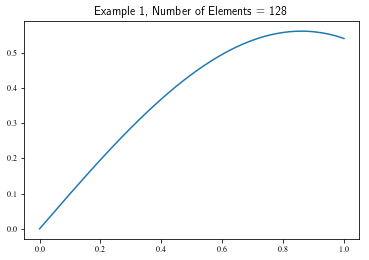

In [125]:
number_coarse = 4
basis_type = 102
print ("h      maximum absolute error    order")
err = np.zeros(6)
for i in range (6):
    number_of_elements = number_coarse*2**i
    if (i < 5):
        err[i], _, _ = Poisson1D_solver(left_boundary_ex1, right_boundary_ex1, number_of_elements, basis_type,\
                             Gpn, coeff_fun_ex1, source_fun_ex1, Dirichlet_fun_ex1, exact_fun_ex1)
    elif (i == 5):
        err[i], Pb, u = Poisson1D_solver(left_boundary_ex1, right_boundary_ex1, number_of_elements, basis_type,\
                             Gpn, coeff_fun_ex1, source_fun_ex1, Dirichlet_fun_ex1, exact_fun_ex1)
    if (i == 0):
        print ("1/%-3d         %7.2e            --" % (number_of_elements, err[i]))
    else:
        print ("1/%-3d         %7.2e           %4.2f" % (number_of_elements, err[i], np.log(err[i-1]/err[i])/np.log(2)))

plt.plot(Pb, u)
plt.title("Example 1, Number of Elements = %3d" % number_of_elements)
plt.show()